# **Initializing And Loading Data**
https://www.kaggle.com/datasets/quora/question-pairs-dataset

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import random
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DUMP_PATH = "/content/drive/MyDrive/Colab Notebooks/dumps/quora_question_pairs/"
NOTEBOOK_NAME = "dl-02-2"
TEST_SIZE = 0.25

## Preprocessing Function

In [ ]:
import nltk

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

abbv = {
    "AFAIK":"as far as I know", "IMO":	"in my opinion", "IMHO":	"in my humble opinion", "LGTM":	"look good to me", "AKA":	"also know as", "ASAP":	"as sone as possible", "BTW":	"by the way", "FAQ":	"frequently asked questions", "DIY":	"do it yourself", "DM":	"direct message", "FYI":	"for your information", "IC":	"i see", "IOW":	"in other words", "IIRC":	"If I Remember Correctly", "icymi":"In case you missed it", "CUZ":	"because", "COS":	"because", "nv":	"nevermind", "PLZ":	"please",
}

# https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
# https://stackoverflow.com/a/19794953
contractions = { 
    "ain't": "am not", "aren't": "are not", "can't": "can not", "can't've": "can not have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "'ve": " have", "n't": " not", "'re": " are", "'ll": " will",
}

import re
html_pattern = re.compile('<.*?>')
urls_pattern = re.compile(r'https?://\S+|www\.\S+')
emoji_pattern = re.compile("["
	u"\U0001F600-\U0001F64F"  # emoticons
	u"\U0001F300-\U0001F5FF"  # symbols & pictographs
	u"\U0001F680-\U0001F6FF"  # transport & map symbols
	u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
"]+", flags=re.UNICODE)

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import string
punc = string.punctuation

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def preprocess(q, allow_stopwords=True):
    
    q = str(q).lower().strip()

    # HTML Tags
    q = html_pattern.sub(r'', q)

    # urls
    q = urls_pattern.sub(r'', q)

    # punctuations
    q = q.translate(str.maketrans("", "", punc))

    # Emojis
    q = emoji_pattern.sub(r'', q)
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    new_text = []

    for word in q.split():

        # Contractions
        word = contractions.get(word.upper(), word)

        # abbreviations
        word = abbv.get(word.upper(), word)
            
        # Stemming
        # word = ps.stem(word)

        # Lemmatizing
        word = lemmatizer.lemmatize(word)

        if word not in stopwords or allow_stopwords:
            new_text.append(word)

    q = ' '.join(new_text)

    
    return q

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Processed Data

In [ ]:
os.listdir(DUMP_PATH)

['more_preprocessed_data_298550.csv',
 'less_nosw_preprocessed_298550.csv',
 'dl-25-3_emb_weights_gensim.npy',
 'back1',
 'dl-25-6_tokenizer.json',
 'dl-25-6_summary.png',
 'dl-25-6_graph_A0.762_E8_B32.png',
 'dl-25-6_model_A0.762_E8_B32.h5',
 'final_preprocessed_data_allowStopwords1.csv',
 'final_preprocessed_data_allowStopwords0.csv',
 'ml-02-1_word_embeddings.json',
 'ml-02-1_model_0.797.pkl',
 'ml-02-1_model_0.791.pkl',
 'ml-02-1_scaler.pkl',
 'ml-02-1_model.pkl',
 'dl-02-1_tokenizer.json',
 'dl-02-1_summary.png',
 'dl-02-1_graph_A0.757_E8_B32.png',
 'dl-02-1_model.h5']

In [ ]:
# DATASET_PATH = os.path.join(DUMP_PATH, 'final_preprocessed_data_allowStopwords1.csv')
# df_stopword1 = pd.read_csv(DATASET_PATH)

In [ ]:
DATASET_PATH = os.path.join(DUMP_PATH, 'final_preprocessed_data_allowStopwords1.csv')

df = pd.read_csv(DATASET_PATH)

# Replacing by original questions
# df['question1'] = df_stopword1['question1']
# df['question2'] = df_stopword1['question2']

# Shuffling the Dataset
df = df.sample(df.shape[0],random_state=2)

print(df.shape)
df.sample(5)

(298550, 29)


,id,qid1,qid2,question1,question2,is_duplicate,cos_sim,q1_len,q2_len,q1_num_words,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,longest_substr_ratio,fuzz_ratio,fuzz_partial_ratio,token_sort_ratio,token_set_ratio
277983,229529,452318,452319,what are the challenge of a supply chain,what are some of the challenge face by new sup...,0,0.714437,40,63,8,...,0.583328,0.0,1.0,4.0,10.0,0.365854,74,75,74,97
280411,183444,362276,362277,which fruit and vegetable help to increase the...,what would happen if i cut down all the sugar ...,0,0.166674,52,75,9,...,0.124999,0.0,0.0,7.0,12.5,0.132075,22,31,38,36
187235,231265,455695,455696,india independance movement is violent or nonv...,by banning of r 500 and r 1k note what will be...,0,0.000008,52,76,7,...,0.000000,0.0,0.0,11.0,12.5,0.056604,22,25,22,22
131475,348091,682019,682020,how do i concentrate in a better way on study,how do i concentrate better on my study,1,0.782626,45,39,10,...,0.699993,1.0,1.0,2.0,9.0,0.525000,86,77,88,96
96060,265999,523307,523308,what is the best way for a woman to gain weigh...,why am i gaining so much weight when i hardly ...,0,0.054560,94,58,20,...,0.050000,0.0,0.0,8.0,16.0,0.135593,38,50,42,39


## Original Data

In [ ]:
MIN_LEN_ALLOWED = 3
SAMPLE_SIZE = None

In [ ]:
! mkdir ~/.kaggle
! cp "/content/drive/MyDrive/Colab Notebooks/docs/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d quora/question-pairs-dataset
! unzip question-pairs-dataset.zip -d data/

100% 20.8M/20.8M [00:02<00:00, 18.2MB/s]
100% 20.8M/20.8M [00:02<00:00, 10.7MB/s]
Archive:  question-pairs-dataset.zip
  inflating: data/questions.csv      


In [ ]:
df = pd.read_csv("/content/data/questions.csv")

# Removing Short Question Rows
short_question_rows = [i for i in range(len(df)) if len(str(df['question1'].iloc[i]).split()) < MIN_LEN_ALLOWED or len(str(df['question2'].iloc[i]).split()) < MIN_LEN_ALLOWED]
df = df.drop(df.index[short_question_rows])

# Removing Duplicates
df.drop_duplicates(inplace=True)

# Shuffling the Dataset
df = df.sample(df.shape[0], random_state=42)

# Picking a sample
if SAMPLE_SIZE == None:
    SAMPLE_SIZE = min(df.is_duplicate.value_counts().values) * 2
df = pd.concat([
    df[df.is_duplicate == 0].iloc[:SAMPLE_SIZE//2],
    df[df.is_duplicate == 1].iloc[:SAMPLE_SIZE//2]
])

# Shuffling the Dataset Again
df = df.sample(df.shape[0],random_state=2)

print("SAMPLE_SIZE", SAMPLE_SIZE)
print(df.shape)
df.sample(5)

SAMPLE_SIZE 298550
(298550, 6)


,id,qid1,qid2,question1,question2,is_duplicate
389765,389765,761898,761899,What's the importance of studying the English ...,Why is English important in psychology?,1
200129,200129,394946,394947,"If you had 100 trillion dollars, what would yo...","If you had 100 billion dollars, what would you...",1
373526,373526,730836,730837,Is Skrill safe enough to use?,WHAT IT SYSTEM CAN I DESIGN FOR MY 4th year pr...,0
362604,362604,709893,709894,What is the standard height for a fireplace ma...,Why does a pilot light go out on a gas fireplace?,0
227986,227986,449294,449295,What is a pardon turkey and why do they get pa...,Why do US Presidents pardon a turkey around Th...,0


In [ ]:
abbv = {
    "AFAIK":"as far as I know", "IMO":	"in my opinion", "IMHO":	"in my humble opinion", "LGTM":	"look good to me", "AKA":	"also know as", "ASAP":	"as sone as possible", "BTW":	"by the way", "FAQ":	"frequently asked questions", "DIY":	"do it yourself", "DM":	"direct message", "FYI":	"for your information", "IC":	"i see", "IOW":	"in other words", "IIRC":	"If I Remember Correctly", "icymi":"In case you missed it", "CUZ":	"because", "COS":	"because", "nv":	"nevermind", "PLZ":	"please",
}

# https://en.wikipedia.org/wiki/Wikipedia%3aList_of_English_contractions
# https://stackoverflow.com/a/19794953
contractions = { 
    "ain't": "am not", "aren't": "are not", "can't": "can not", "can't've": "can not have", "'cause": "because", "could've": "could have", "couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would", "he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is", "i'd": "i would", "i'd've": "i would have", "i'll": "i will", "i'll've": "i will have", "i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have", "it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have", "mightn't": "might not", "mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have", "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have", "so's": "so as", "that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are", "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would", "y'all'd've": "you all would have", "y'all're": "you all are", "y'all've": "you all have", "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have", "'ve": " have", "n't": " not", "'re": " are", "'ll": " will",
}

import re
html_pattern = re.compile('<.*?>')
urls_pattern = re.compile(r'https?://\S+|www\.\S+')
emoji_pattern = re.compile("["
	u"\U0001F600-\U0001F64F"  # emoticons
	u"\U0001F300-\U0001F5FF"  # symbols & pictographs
	u"\U0001F680-\U0001F6FF"  # transport & map symbols
	u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
"]+", flags=re.UNICODE)

from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

import string
punc = string.punctuation

from nltk.corpus import stopwords
stopwords = stopwords.words('english')

def preprocess(q):
    
    q = str(q).lower().strip()

    # HTML Tags
    q = html_pattern.sub(r'', q)

    # urls
    q = urls_pattern.sub(r'', q)

    # punctuations
    q = q.translate(str.maketrans("", "", punc))

    # Emojis
    q = emoji_pattern.sub(r'', q)
    
    # Replace certain special characters with their string equivalents
    q = q.replace('%', ' percent')
    q = q.replace('$', ' dollar ')
    q = q.replace('₹', ' rupee ')
    q = q.replace('€', ' euro ')
    q = q.replace('@', ' at ')
    
    # The pattern '[math]' appears around 900 times in the whole dataset.
    q = q.replace('[math]', '')
    
    # Replacing some numbers with string equivalents (not perfect, can be done better to account for more cases)
    q = q.replace(',000,000,000 ', 'b ')
    q = q.replace(',000,000 ', 'm ')
    q = q.replace(',000 ', 'k ')
    q = re.sub(r'([0-9]+)000000000', r'\1b', q)
    q = re.sub(r'([0-9]+)000000', r'\1m', q)
    q = re.sub(r'([0-9]+)000', r'\1k', q)
    
    # Decontracting words
    new_text = []

    for word in q.split():

        # Contractions
        word = contractions.get(word.upper(), word)

        # abbreviations
        word = abbv.get(word.upper(), word)
            
        # Stemming
        # word = ps.stem(word)

        # Lemmatizing
        word = lemmatizer.lemmatize(word)

        # if word not in stopwords:
        #     new_text.append(word)
        new_text.append(word)

    q = ' '.join(new_text)

    
    return q

In [ ]:
q1 = []
for i in tqdm(df['question1'].values):
    q1.append(preprocess(i))

q2 = []
for i in tqdm(df['question2'].values):
    q2.append(preprocess(i))

100%|██████████| 298550/298550 [00:28<00:00, 10577.53it/s]


In [ ]:
new_df = df[['question1', 'question2', 'is_duplicate']]

In [ ]:
new_df['question1'] = q1
new_df['question2'] = q2

<ipython-input-78-5cdb8f4ae90f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['question1'] = q1
<ipython-input-78-5cdb8f4ae90f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['question2'] = q2


In [ ]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
81424,81424,161740,161741,Why can't India get more medals in every Olymp...,Why do Indians get less medals in Olympics?,1
350428,350428,686512,686513,Are car accidents more common among high schoo...,Were carriage accidents more or less common th...,0
162442,162442,321149,321150,What is conceptual analysis?,What is a conceptual model?,0
261498,261498,514570,514571,"What is the eye in ""The Lord of the Rings""?",Who's the most powerful in the Lord of the Rings?,0
70085,70085,139301,139302,How is management both an art and a science?,Why is management both a science and an art?,1


In [ ]:
new_df.head()

,question1,question2,is_duplicate
81424,why cant india get more medal in every olympics,why do indian get le medal in olympics,1
350428,are car accident more common among high school...,were carriage accident more or le common than ...,0
162442,what is conceptual analysis,what is a conceptual model,0
261498,what is the eye in the lord of the ring,who the most powerful in the lord of the ring,0
70085,how is management both an art and a science,why is management both a science and an art,1


In [ ]:
new_df.to_csv(os.path.join(DUMP_PATH, f"less_nosw_preprocessed_{SAMPLE_SIZE}"), index=False)

## Splitting

In [ ]:
slice_i = int(len(df) * TEST_SIZE / 2)
slice_i

37318

In [ ]:
df = df.sample(df.shape[0], random_state=42)

train = pd.concat([
    df[df.is_duplicate == 0][slice_i:],
    df[df.is_duplicate == 1][slice_i:],
])
test = pd.concat([
    df[df.is_duplicate == 0][:slice_i],
    df[df.is_duplicate == 1][:slice_i],
])

train = train.sample(train.shape[0], random_state=42)
test = test.sample(test.shape[0], random_state=42)

del df

train.shape, test.shape

((223914, 29), (74636, 29))

In [ ]:
train_q1_arr = [str(i) for i in train['question1']]
train_q2_arr =  [str(i) for i in train['question2']]

test_q1_arr = [str(i) for i in test['question1']]
test_q2_arr =  [str(i) for i in test['question2']]

# train_feats_arr = train.drop(columns=['is_duplicate', 'id','qid1','qid2','question1','question2']).values
# test_feats_arr = test.drop(columns=['is_duplicate', 'id','qid1','qid2','question1','question2']).values

train_y_arr = train['is_duplicate'].values
test_y_arr = test['is_duplicate'].values

del train
del test

# **Vectorizing**

In [ ]:
OOV_TOKEN = "<OOV>"
VOCAB_SIZE = 8_000

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(
	num_words = VOCAB_SIZE,			# vocab size
	oov_token = OOV_TOKEN,	    	# word out of vocab to replace with
	filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n',
	lower = True,
)

# Fitting
tokenizer.fit_on_texts(train_q1_arr + train_q2_arr)

# Transforming

train_q1_arr = tokenizer.texts_to_sequences(train_q1_arr)
# train_q1_arr = pad_sequences(train_q1_arr, maxlen=MAXLEN)

train_q2_arr = tokenizer.texts_to_sequences(train_q2_arr)
# train_q2_arr = pad_sequences(train_q2_arr, maxlen=MAXLEN)

test_q1_arr = tokenizer.texts_to_sequences(test_q1_arr)
# test_q1_arr = pad_sequences(test_q1_arr, maxlen=MAXLEN)

test_q2_arr = tokenizer.texts_to_sequences(test_q2_arr)
# test_q2_arr = pad_sequences(test_q2_arr, maxlen=MAXLEN)

In [ ]:
tf_train_q1_arr = tf.ragged.constant(train_q1_arr)
tf_train_q2_arr = tf.ragged.constant(train_q2_arr)
tf_test_q1_arr = tf.ragged.constant(test_q1_arr)
tf_test_q2_arr = tf.ragged.constant(test_q2_arr)

del train_q1_arr
del train_q2_arr
del test_q1_arr
del test_q2_arr

## Saving

In [ ]:
tokenizer_path = os.path.join(DUMP_PATH, f"{NOTEBOOK_NAME}_tokenizer.json")
tokenizer_path

'/content/drive/MyDrive/Colab Notebooks/dumps/quora_question_pairs/dl-02-2_tokenizer.json'

In [ ]:
import json

with open(tokenizer_path, 'w') as f:
    json.dump(tokenizer.to_json(), f)

# **Modelling**

## Embeddings

### Preparing Embeddings

In [ ]:
import gensim

#### Pretrained Embedding GoogleNews-vectors-negative300

In [ ]:
from gensim.models import KeyedVectors

In [ ]:
! kaggle datasets download -d leadbest/googlenewsvectorsnegative300
! unzip googlenewsvectorsnegative300.zip
! ls

In [ ]:
word_2_vec = KeyedVectors.load_word2vec_format(
	'GoogleNews-vectors-negative300.bin',
	binary=True,
	limit=500000
)

#### Training New Embeddings using gensim

In [ ]:
from gensim.utils import simple_preprocess

In [ ]:
story = train['question1'].values.tolist() + train['question2'].values.tolist()
story = [simple_preprocess(str(i)) for i in story]
len(story), story[:2]

(447828,
 [['what',
   'are',
   'the',
   'similarity',
   'and',
   'difference',
   'of',
   'skimming',
   'and',
   'scanning'],
  ['harry',
   'potter',
   'what',
   'did',
   'mcgonagal',
   'do',
   'in',
   'her',
   'free',
   'time']])

In [ ]:
gensim_model = gensim.models.Word2Vec(
    window=1,      # sliding side, words to take before and after target
    min_count=2,    # take sentences with atleast 2 words
)
gensim_model.build_vocab(story)
gensim_model.train(
    story,
    total_examples = len(story),
    epochs = 5,
)
word_2_vec = gensim_model.wv

(16091963, 22582445)

#### Setting Weights

In [ ]:
VOCAB = list(tokenizer.index_word.values())[1:VOCAB_SIZE-1]

In [ ]:
len(VOCAB), VOCAB[-1]

(7998, 'testicle')

In [ ]:
new_weights = []
for i, V in enumerate(VOCAB):
    i += 2
    try:
        vec = word_2_vec[V]
        new_weights.append(vec)
    except: pass
new_weights = np.array(new_weights)

mean = new_weights.mean()
std = new_weights.std()

print(mean, std)

-0.016804894 0.38171214


In [ ]:
emb_dims = new_weights.shape[-1]
emb_dims

100

In [ ]:
new_weights = [
    np.random.normal(mean, std, size=(emb_dims,)),
    np.random.normal(mean, std, size=(emb_dims,))
]
for i, V in enumerate(VOCAB):
    i += 2
    try:
        vec = word_2_vec[V]
        new_weights.append(vec)
    except:
        vec = np.random.normal(mean, std, size=(emb_dims,))
        new_weights.append(vec)
new_weights = np.array(new_weights)
new_weights.shape

(8000, 100)

In [ ]:
EMB_WEIGHTS_PATH = os.path.join(DUMP_PATH, f"{NOTEBOOK_NAME}_emb_weights_gensim")
EMB_WEIGHTS_PATH

'/content/drive/MyDrive/Colab Notebooks/dumps/quora_question_pairs/dl-25-3_emb_weights_gensim'

In [ ]:
np.save(EMB_WEIGHTS_PATH, new_weights)

### Loading Embeddings

In [ ]:
os.listdir(DUMP_PATH)

['more_preprocessed_data_298550.csv',
 'less_nosw_preprocessed_298550.csv',
 'dl-25-3_emb_weights_gensim.npy',
 'back1',
 'dl-25-6_tokenizer.json',
 'dl-25-6_summary.png',
 'dl-25-6_graph_A0.762_E8_B32.png',
 'dl-25-6_model_A0.762_E8_B32.h5',
 'final_preprocessed_data_allowStopwords1.csv',
 'final_preprocessed_data_allowStopwords0.csv',
 'ml-02-1_word_embeddings.json',
 'ml-02-1_model_0.797.pkl',
 'ml-02-1_model_0.791.pkl',
 'ml-02-1_scaler.pkl',
 'ml-02-1_model.pkl',
 'dl-02-1_tokenizer.json',
 'dl-02-1_summary.png',
 'dl-02-1_graph_A0.757_E8_B32.png',
 'dl-02-1_model.h5',
 'dl-02-2_tokenizer.json']

In [ ]:
new_weights = np.load(os.path.join(DUMP_PATH, 'dl-25-3_emb_weights_gensim.npy'))

In [ ]:
new_weights.shape

(8000, 100)

### Visualizing Embeddings

In [ ]:
EMB_VEC_PATH = os.path.join(DUMP_PATH, f"{NOTEBOOK_NAME}_emb_vec.tsv")
EMB_VOC_PATH = os.path.join(DUMP_PATH, f"{NOTEBOOK_NAME}_emb_vocab.tsv")
EMB_GRAPH_PATH = os.path.join(DUMP_PATH, f"{NOTEBOOK_NAME}_emb_graph.png")
EMB_VEC_PATH, EMB_VOC_PATH, EMB_GRAPH_PATH

('/content/drive/MyDrive/Colab Notebooks/dumps/quora_question_pairs/dl-25-4_emb_vec.tsv',
 '/content/drive/MyDrive/Colab Notebooks/dumps/quora_question_pairs/dl-25-4_emb_vocab.tsv',
 '/content/drive/MyDrive/Colab Notebooks/dumps/quora_question_pairs/dl-25-4_emb_graph.png')

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

emb_weights = new_weights[2:].round(5)
emb_cols = list(tokenizer.index_word.values())[1:VOCAB_SIZE-1]
sim = cosine_similarity(emb_weights)
emb_weights.shape, len(emb_cols), sim.shape

((7998, 100), 7998, (7998, 7998))

In [ ]:
with open(EMB_VOC_PATH, 'w') as f:
    f.write("\n".join(emb_cols))
emb_weights.tofile(EMB_VEC_PATH, sep="\t")

In [ ]:
" ".join(random.choices(emb_cols, k=200))

'audio individual notable ignorant atom jew reducing compiler geology cluster eligibility warren passing upto mma clinton irish hell carrie ivanka thinking k3 cashless general legitimate jpeg cup central pant write lover implant jack dual checking decides participate tim cooker 11th stressed muscle woman doubt discount geology millionaire nomination allo erect ww2 outer nonvegetarian carbon upgrade walker here scoring dentist cup scientific belt command risk ur climb thumb marine seller 53 1krs launched heating relative taking disney rs15k specification secretary vietnamese legend prototype memory seeing variety receive sheldon powerpoint uae plagiarism starving belly skip buddhism proper confess performing sandwich wizard draft tampon mnc beat rating don’t bonus modified clear vinegar textbook dial hydroxide sarcastic circular puppy sausage hyundai capitalism fastest requested vacuum compile height fridge soppy nougat bluray till exercising meat frost visualization air accent hardware

In [ ]:
word = "millionaire"
n = 200

ind = emb_cols.index(word)
sim_ind = [i[0] for i in sorted(enumerate(sim[ind]), key=lambda x: x[1], reverse=True)][1:n+1]

print(f"Similar Words For '{word}'")
" ".join(np.array(emb_cols)[sim_ind])

Similar Words For 'millionaire'


'billionaire potus disciplined immortal charismatic jerk invisible dentist witch buddhist attempting happier taxed extinct wealthy diplomat puberty dictator superpower eaten superhero wanted embarrassed saint assassinated rich consumed hypocrite studied hired recovered confident genius villain curious hated served wanting entrepreneur existed remembered alive murdered cop defeated influenced lawyer finished drunk inspired doctor successful rejected hungry pornstar enlightened narcissist richer respected intjs believed invested learned held blamed smarter decided disappointed comma tibet achieved physicist conquered unsafe boring punished ruled raped attended followed destroyed performed regarded merged portrayed revealed homeless vijay meant promoted talented preferable focused learnt googling invaded mature observed founded jr forced philosopher lesbian shareholder offended willing claimed worried eventually cancelled extrovert economically boxing prevented died appeared solved mutant

[47, 60, 7]


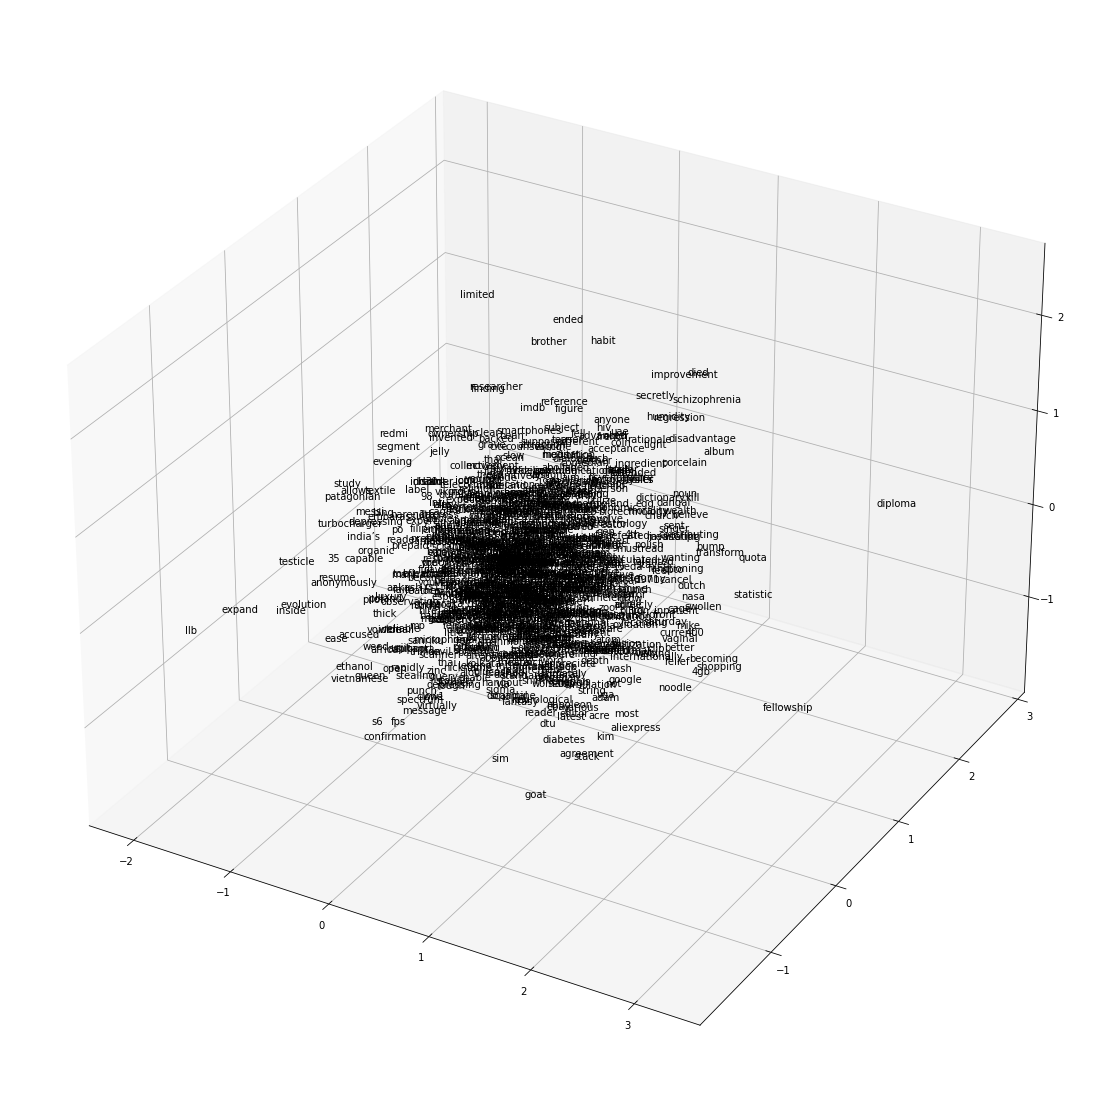

In [ ]:
limit = 1000
i_dims = random.choices(range(emb_weights.shape[-1]), k=3)
print(i_dims)
i_cols = random.choices(range(len(emb_cols)), k=limit)

from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import scale

x1, x2, x3 = emb_weights[:, i_dims].T

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

for i, label in enumerate(np.array(emb_cols)[i_cols]):
    ax.text(x1[i], x2[i], x3[i], label, fontsize=10)

ax.scatter(x1, x2, x3, s=0)

plt.savefig(EMB_GRAPH_PATH)
plt.show()

## Architechture

/content/drive/MyDrive/Colab Notebooks/dumps/quora_question_pairs/dl-02-2_summary.png


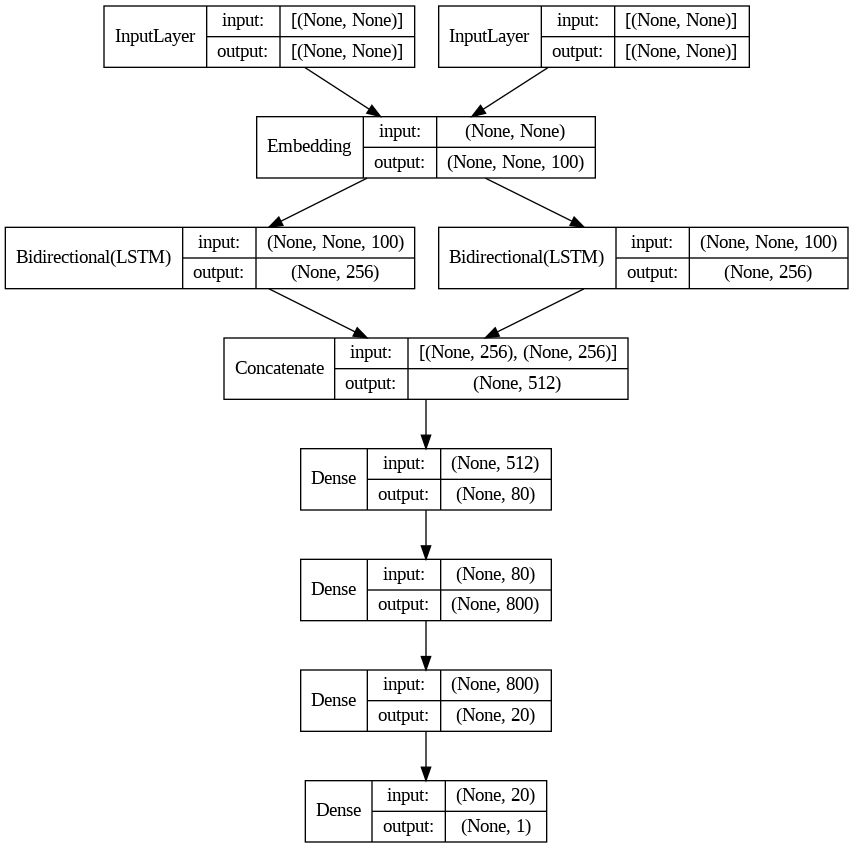

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
import tensorflow.keras.backend as K
from keras.utils.vis_utils import plot_model

# EMB_DIM = 300
LSTM_DIM = 128
REG_L2 = 0.00001

# INPUTS
l_input_q1 = layers.Input(shape=[None])
l_input_q2 = layers.Input(shape=[None])

# EMBEDDING
EMB_LAYER = tf.keras.layers.Embedding(
    new_weights.shape[0],   # vocab size
    new_weights.shape[1],   # embedding dims
)
l_embed_q1 = EMB_LAYER(l_input_q1)
l_embed_q2 = EMB_LAYER(l_input_q2)

# LSTM
l_lstm_q1 = layers.Bidirectional(
    layers.LSTM(LSTM_DIM, kernel_regularizer=regularizers.l2(REG_L2), return_sequences=False),
)(l_embed_q1)
l_lstm_q2 = layers.Bidirectional(
    layers.LSTM(LSTM_DIM, kernel_regularizer=regularizers.l2(REG_L2), return_sequences=False),
)(l_embed_q2)

# COMBINING
def cosine_similarity(x):
    left, right = x
    dot_product = K.sum(left * right, axis=1, keepdims=True)
    left_norm = K.sqrt(K.sum(K.square(left), axis=1, keepdims=True))
    right_norm = K.sqrt(K.sum(K.square(right), axis=1, keepdims=True))
    cosine_sim = dot_product / (left_norm * right_norm) # [-1, 1]
    range_multiplier = 2.5
    return cosine_sim * range_multiplier

# Define lambda layer to compute cosine similarity
# l_combined = layers.Lambda(cosine_similarity)([l_lstm_q1, l_lstm_q2])
l_combined = layers.Concatenate()([l_lstm_q1, l_lstm_q2])
l_combined = layers.Dense(80, activation='relu')(l_combined)
l_combined = layers.Dense(800, activation='relu')(l_combined)
l_combined = layers.Dense(20, activation='relu')(l_combined)
l_combined = layers.Dense(1, activation='sigmoid')(l_combined)

# OUTPUT
l_output = layers.Activation('sigmoid')(l_combined)

# CONNECTING
model = models.Model(inputs=[l_input_q1, l_input_q2], outputs=l_combined)

SUMMARY_IMAGE_PATH = os.path.join(DUMP_PATH, f'{NOTEBOOK_NAME}_summary.png')
print(SUMMARY_IMAGE_PATH)
plot_model(model, to_file=SUMMARY_IMAGE_PATH, show_shapes=True, show_layer_names=False)

## Applying Embedding Weights

In [ ]:
tokenizer.index_word[VOCAB_SIZE]

'outstanding'

In [ ]:
EMB_LAYER.set_weights([new_weights])
EMB_LAYER.trainable = False

In [ ]:
model.summary()

## Training

In [ ]:
EPOCHS = 8
BATCH_SIZE = 32
# LR = 0.001
# MOMENTUN = 0.98
# VALIDATION_STEPS = 100

N = len(train_y_arr)    # n_total_training_samples_used_in_model
STEPS_PER_EPOCH = int(np.floor(N / (EPOCHS * BATCH_SIZE)))

print(f"""
    epochs: {EPOCHS}
    batch_size: {BATCH_SIZE}
    steps_per_epoch: {STEPS_PER_EPOCH}
    total available samples: {len(train_y_arr)}
    total taken samples: {N}
    samples seen in one epoch: {BATCH_SIZE * STEPS_PER_EPOCH}
    samples seen in all epoch: {BATCH_SIZE * STEPS_PER_EPOCH * EPOCHS}
    samples unseen: {len(train_y_arr) - BATCH_SIZE * STEPS_PER_EPOCH * EPOCHS}
""")


"""
- n_total_training_samples_used_in_model = batch_size * steps_per_epoch * epochs
- gradients are calculated after every batch i.e after every step in an epoch
- average is taken for gradients over all batches in an epoch and finally weights are updated after the end of epoch
- performance is evaluated after every epoch
"""

model.compile(
    # optimizer=optimizers.Adam(
    #     learning_rate=LR
    # ),
    optimizer = 'adam',
    loss='binary_crossentropy', metrics=['acc']
)
with tf.device('/GPU:0'):
    history = model.fit(
        [tf_train_q1_arr, tf_train_q2_arr],
        train_y_arr,
        epochs = EPOCHS,
        validation_data = (
            [tf_test_q1_arr, tf_test_q2_arr],
            test_y_arr
        ),
        batch_size = BATCH_SIZE,
        steps_per_epoch = int(np.ceil(N / (EPOCHS * BATCH_SIZE)))
        # validation_steps = VALIDATION_STEPS
    ).history


    epochs: 8
    batch_size: 32
    steps_per_epoch: 874
    total available samples: 223914
    total taken samples: 223914
    samples seen in one epoch: 27968
    samples seen in all epoch: 223744
    samples unseen: 170

Epoch 1/8
875/875 [==============================] - 45s 37ms/step - loss: 0.5997 - acc: 0.6847 - val_loss: 0.5651 - val_acc: 0.7127
Epoch 2/8
875/875 [==============================] - 36s 41ms/step - loss: 0.5571 - acc: 0.7205 - val_loss: 0.5518 - val_acc: 0.7264
Epoch 3/8
875/875 [==============================] - 32s 36ms/step - loss: 0.5429 - acc: 0.7292 - val_loss: 0.5316 - val_acc: 0.7324
Epoch 4/8
875/875 [==============================] - 31s 34ms/step - loss: 0.5256 - acc: 0.7413 - val_loss: 0.5331 - val_acc: 0.7356
Epoch 5/8
875/875 [==============================] - 31s 34ms/step - loss: 0.5202 - acc: 0.7449 - val_loss: 0.5378 - val_acc: 0.7331
Epoch 6/8
875/875 [==============================] - 31s 35ms/step - loss: 0.5068 - acc: 0.7558 - val_loss: 

## Analyzing Layers

In [ ]:
preds = model.predict([tf_train_q1_arr, tf_train_q2_arr]).ravel()
print("train mean:", preds.mean())
plt.hist(preds)
plt.show()

preds = model.predict([tf_test_q1_arr, tf_test_q2_arr]).ravel()
print("test mean:", preds.mean())
plt.hist(preds)
plt.show()

del preds

In [ ]:
for i, l in enumerate(model.layers):
    print(i, l)

In [ ]:
# i = 0

# x1 = tf.gather(tf_test_q1_arr, i, axis=0)
# x1 = tf.reshape(x1, (1, *x1.shape))
# x2 = tf.gather(tf_test_q2_arr, i, axis=0)
# x2 = tf.reshape(x2, (1, *x2.shape))

# x1 = model.layers[0](tf_test_q1_arr)
# x2 = model.layers[1](tf_test_q2_arr)

# x1 = model.layers[2](x1)
# x2 = model.layers[2](x2)

# x1 = model.layers[3](x1)
# x2 = model.layers[4](x2)

# x = model.layers[5]([x1, x2])
# del x1
# del x2

# x.shape

## Metrics

In [ ]:
val_acc = history['val_acc'][-1]
# val_acc = evalutaion[1]
print("Validation Accuracy: ", val_acc)

In [ ]:
keys = ['acc', 'loss']

fig, axes = plt.subplots(
	len(keys),  # no of rows
	1,          # no of cols
	figsize = (18, 4*len(keys)),
)
fig.subplots_adjust(hspace=0.3)

for i, key in enumerate(keys):
    ax = axes[i]
    ax.set_title("Plot For " + key)
    for hist_key in [i for i in history.keys() if key in i]:
        ax.plot(history[hist_key], label=hist_key)
    ax.legend()
    ax.set_xlabel("Epochs")
    ax.set_ylabel(key)

# # Saving the figure
GRAPH_PATH = os.path.join(DUMP_PATH, f"{NOTEBOOK_NAME}_graph_A{round(val_acc, 3)}_E{EPOCHS}_B{BATCH_SIZE}.png")
print(GRAPH_PATH)
plt.savefig(GRAPH_PATH)

plt.show()

## Saving

In [ ]:
# MODEL_PATH = os.path.join(DUMP_PATH, f"{NOTEBOOK_NAME}_model_A{round(val_acc, 3)}_E{EPOCHS}_B{BATCH_SIZE}.h5")
# MODEL_PATH

In [ ]:
MODEL_PATH = os.path.join(DUMP_PATH, f"{NOTEBOOK_NAME}_model.h5")
MODEL_PATH

In [ ]:
model.save(MODEL_PATH)

## Realtime Testing

In [ ]:
def get_pred(ques1, ques2):

    q1 = tf.ragged.constant(tokenizer.texts_to_sequences([preprocess(ques1)]))
    q2 = tf.ragged.constant(tokenizer.texts_to_sequences([preprocess(ques2)]))

    return model.predict([q1, q2])[0, 0]

In [ ]:
cases = [
	[
		"who is the prime minister of Pakistan",
		"who is current prime minister of Pakistan",
        1
	],
	[
		"who is the prime minister of Pakistan",
		"who is the prime minister of India",
        0
	],
    [
		"what is the name of first prime minister of pakistan.",
		"who was first prime minister of pakistan.",
		1
	],
    [
		"what are some of the stereo types regarding Russians",
		"what are some of the stereo types regarding chinese",
		0
	],
    [
		"what are some of the stereo types regarding Russians",
		"I know russians have a lot of stereo types, can you name any",
		1
	],
    [
		"how big is sun as compared to earth",
		"sun is how much bigger than earth",
		1
	],
    [
		"what is the most searched website in Pakistan in 2022",
		"what is the most searched website in India in 2022",
		0
	],
    [
		"what is your name",
		"what name you have",
		1
	],
    [
		"What is the capital of France?",
		"What is the name of the capital city of France?",
		1
	],
    [
		"What is the population of New York City?",
		"How many people live in New York City?",
		1
	],
    [
		"Who directed the movie 'The Dark Knight'?",
		"What is the name of the director of 'The Dark Knight'?",
		1
	],
    [
		"What is the highest mountain in Africa?",
		"Which mountain is the tallest in Africa?",
		1
	],
    [
		"What is the chemical formula for water?",
		"What is the molecular formula for H2O?",
		1
	],
    [
		"What is the name of the first man on the moon?",
		"Who was the astronaut that landed on the moon first?",
		1
	],
    [
		"What is the largest ocean on Earth?",
		"Which ocean is the biggest in terms of volume?",
		1
	],
    [
		"What is the capital of Japan?",
		"Which city is the capital of Japan?",
		1
	],
    [
		"What is the name of the longest river in South America?",
		"Which river holds the title for being the longest in South America?",
		1
	],
    [
		"Who is the author of 'The Great Gatsby'?",
		"What is the name of the person who wrote 'The Great Gatsby'?",
		1
	],
    [
		"What is the boiling point of water at sea level?",
		"What is the freezing point of water at sea level?",
		0
	],
    [
		"What is the meaning of the word 'perplexed'?",
		"What is the definition of the word 'baffled'?",
		0
	],
    [
		"Who won the Academy Award for Best Picture in 2020?",
		"Who won the Academy Award for Best Actor in 2020?",
		0
	],
    [
		"What is the capital of Australia?",
		"What is the capital of New Zealand?",
		0
	],
    [
		"What is the name of the largest desert in the world?",
		"What is the name of the longest river in the world?",
		0
	],
    [
		"What is the capital city of Spain?",
		"What is the name of the capital of Spain?",
		1
	],
    [
		"Who wrote the novel 'To Kill a Mockingbird'?",
		"What is the name of the author of 'To Kill a Mockingbird'?",
		1
	],
    [
		"What is the chemical symbol for gold?",
		"What is the symbol for the element gold on the periodic table?",
		1
	],
    [
		"What is the highest mountain in North America?",
		"What is the name of the tallest peak in North America?",
		1
	],
    [
		"What is the largest planet in our solar system?",
		"Which planet is the biggest in terms of size and mass?",
		1
	],
    [
		"What is the name of the currency used in Japan?",
		"What is the currency of Japan called?",
		1
	],
    [
		"What is the name of the largest ocean on Earth?",
		"Which ocean holds the title for being the largest in terms of surface area and volume?",
		1
	],
    [
		"What is the first name of the actress who played Hermione Granger in the 'Harry Potter' movies?",
		"What is the name of the actress who portrayed the character of Hermione Granger in the 'Harry Potter' film series?",
		1
	],
    [
		"What is the capital of India?",
		"Which city serves as the capital of India?",
		1
	],
    [
		"What is the highest waterfall in the world?",
		"What is the name of the waterfall with the largest drop in the world?",
		1
	],
    [
		"Who played the character of Jack Sparrow in the 'Pirates of the Caribbean' movies?",
		"What is the name of the actor who portrayed Jack Sparrow in the 'Pirates of the Caribbean' film franchise?",
		1
	],
    [
		"What is the name of the largest continent on Earth?",
		"Which continent holds the title for being the biggest in terms of land area and population?",
		1
	],
    [
		"What is the capital of Russia?",
		"What is the name of the city that serves as the capital of Russia?",
		1
	],
    [
		"What is the name of the largest moon in our solar system?",
		"Which moon has the largest size and mass among all the natural satellites orbiting planets in our solar system?",
		1
	],
    [
		"Who directed the movie 'Jurassic Park'?",
		"What is the name of the filmmaker who directed 'Jurassic Park'?",
		1
	],
    [
		"What is the name of the first man to walk on the moon?",
		"Who was the astronaut who first set foot on the lunar surface?",
		1
	],
    [
		"What is the largest state in the United States in terms of land area?",
		"Which state has the biggest land area among all the states that make up the United States of America?",
		1
	],
    [
		"What is the name of the longest river in the world?",
		"Which river holds the title for being the largest in terms of length and discharge?",
		1
	],
    [
		"What is the currency used in the United Kingdom?",
		"What is the name of the currency that is currently in circulation",
		1
	],
]

In [ ]:
len(cases)

In [ ]:
correct = 0
wrong = 0
for case in (cases[:]):
	pred = get_pred(
		case[0],
		case[1]
	)

	if round(pred) == case[2]:
		correct += 1
	else:
		print(case[0])
		print(case[1])
		print(pred, f"correct: {case[2]}\n")
		wrong += 1

print()
print("correct:", correct)
print("wrong:", wrong)